In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
# import string as str

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
connection = engine.connect()

# Exploratory Climate Analysis

,prcp
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


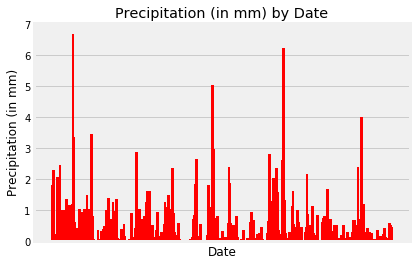

In [214]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# sql_date_ly = "Select max(date) FROM measurement"
# df_date_ly = pd.read_sql_query(sql_date_ly, con=connection)

df = pd.DataFrame(session.query((Measurement.tobs), (Measurement.date)))

max_date = df.date.max()
max_year = int(max_date[0:4])
min_year = str(max_year-1)
min_date = first_year[0:4] + latest_date[4:13]

# latest_date = df_date_ly.iloc[0,0]
# latest_year = int(latest_date[0:4])
# first_year = str(latest_year-1)
# first_date = first_year[0:4] + latest_date[4:13]

# Perform a query to retrieve the data and precipitation scores
# sql_precip = ("SELECT prcp precip, date FROM measurement WHERE date between '" + first_date + "' and '" + latest_date + "';")
df1 = pd.DataFrame(session.query((Measurement.prcp), (Measurement.date)).filter(Measurement.date >= min_date).filter(Measurement.date <= max_date).all())
df1

# Save the query results as a Pandas DataFrame and set the index to the date column
# df_precip = pd.read_sql_query(sql_precip, con=connection)
df_precip = df1
df_precip = df_precip.set_index('date')
df_precip = df_precip.dropna(how='any')
df_precip.head()

# Sort the dataframe by date
df_precip = df_precip.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
x_axis = df_precip.index
y_axis = df_precip.prcp

plt.bar(x_axis, y_axis, color = 'r', width = 3)
plt.xlabel("Date")
plt.xticks([])
plt.ylabel("Precipitation (in mm)")
plt.title("Precipitation (in mm) by Date")
df_precip.head()

![precipitation](Images/precipitation.png)

In [50]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_precip.describe()

The total rainfall in the past year was 358.28mm which averages to 0.18mm a day


,precip
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [254]:
# Design a query to show how many stations are available in this dataset?
sql_stations = "SELECT COUNT(*) as Stations FROM station"

df_stations = pd.read_sql_query(sql_stations, con=connection)
df_stations

df_stations_new = session.query(func.count(Station.station)).all()
print(df_stations_new[0])


(9,)


In [334]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sql_act_stations = "SELECT station, COUNT(*) as measurements FROM measurement GROUP BY station ORDER BY measurements DESC"

df_stations = pd.read_sql_query(sql_act_stations, con=connection)
df_stations

df_stations_all = pd.DataFrame(session.query((Measurement.station), (Measurement.tobs)))
df_stations_all
df_stations_gb = df_stations_all.groupby(['station'])
df_stations_count = df_stations_gb.count().sort_values('tobs', ascending=False)
df_stations_count = df_stations_count.reset_index(drop=False)
df_stations_count
# df_stations

,station,tobs
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [392]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sql_act_station_min_max = "SELECT station, MIN(tobs) Min_Temp, MAX(tobs) Max_Temp, Round(AVG(tobs),2) Avg_Temp \
            FROM measurement \
            WHERE station = (SELECT station FROM measurement GROUP BY station ORDER BY COUNT(*) DESC LIMIT 1) \
            GROUP BY station"

df_station_min_max = pd.read_sql_query(sql_act_station_min_max, con=connection)
df_station_min_max

max_station = df_stations_count.iloc[0,0]
print(max_station)

sel = [Measurement.station,func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
df4 = session.query(*sel).filter(Measurement.station == max_station).all()
print(df4)
df_station_min_max

USC00519281
[('USC00519281', 54.0, 85.0, 71.66378066378067)]


,station,Min_Temp,Max_Temp,Avg_Temp
0,USC00519281,54.0,85.0,71.66


Text(0.5, 1.0, 'Temperature Frequency for WAIHEE')

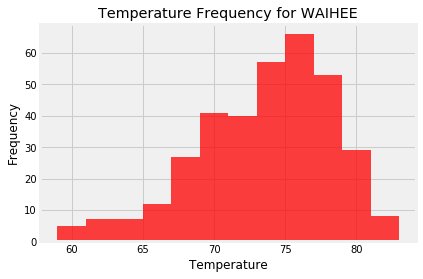

In [391]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# sql_station_high_obs = "SELECT station, tobs FROM measurement \
#             WHERE station = (SELECT station FROM measurement GROUP BY station ORDER BY COUNT(tobs) DESC LIMIT 1) \
#             AND date between '" + first_date + "' and '" + latest_date + "' "

# df_station_high_obs = pd.read_sql_query(sql_station_high_obs, con=connection)
# df_station_high_obs

# station = df_station_high_obs.iloc[0,0]
sql_station = "SELECT name FROM station WHERE station = '" + station + "' "
df_station_name = pd.read_sql_query(sql_station, con=connection)

sel = [Measurement.station, Measurement.tobs]
df_station_high_obs_new = pd.DataFrame(session.query(*sel).filter(Measurement.station == max_station).filter(Measurement.date >= min_date).filter(Measurement.date <= max_date).all())

station_name = df_station_name.iloc[0,0]
station_name = str.split(station_name," ")
station_name = station_name[0]

x_axis = df_station_high_obs_new['tobs']
plt.hist(x_axis, 12, facecolor='red', alpha=0.75)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature Frequency for " + station_name)

![precipitation](Images/station-histogram.png)

In [121]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [122]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps(first_date, latest_date))

[(58.0, 74.59058295964125, 87.0)]


In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [23]:
# Plot the daily normals as an area plot with `stacked=False`
